In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [10]:
import arviz as az
import edge_photometry as ep
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook')
numpyro.set_host_device_count(4)
numpyro.enable_x64()

In [20]:
def truncated_model(xobs, sigma_x, xcut):
    mu = numpyro.sample('mu', dist.Normal(0, 1))
    sigma = numpyro.sample('sigma', dist.HalfNormal(1))
    xedge = numpyro.sample('xedge', dist.Normal(1, 1))

    sigma_obs = jnp.sqrt(sigma*sigma + sigma_x*sigma_x)

    log_alpha = ep.log1p_erf(((xedge-xobs)*sigma*sigma + (xedge-mu)*sigma_x*sigma_x)/(jnp.sqrt(2)*sigma*sigma_x*sigma_obs)) - ep.log1p_erf((xedge-mu)/(jnp.sqrt(2)*sigma))
    log_norm = jnp.log(0.5) + ep.log1p_erf((mu-xcut)/(jnp.sqrt(2)*sigma_obs))

    numpyro.factor('likelihood', jnp.sum(dist.Normal(mu, sigma_obs).log_prob(xobs) + log_alpha - log_norm))


In [25]:
N = 1000

mu = 0.0
sigma = 1.0
xedge = 1.0
xcut = -1.0
s = 0.02

xobs = []
sigma_x = []
n = 0
while n < N:
    x = mu + sigma*np.random.randn()
    if x < xedge:
        xo = x + s*np.random.randn()
        if xo > xcut:
            xobs.append(xo)
            sigma_x.append(s)
            n += 1
xobs = np.array(xobs)
sigma_x = np.array(sigma_x)

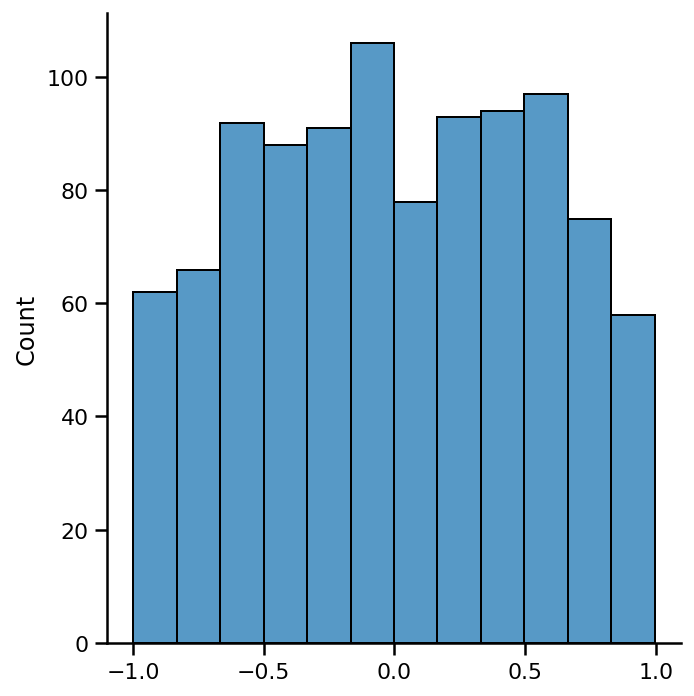

In [26]:
sns.displot(xobs)

In [27]:
num_chains=4
thin=1

sampler = NUTS(truncated_model, dense_mass=True)
mcmc = MCMC(sampler, num_warmup=thin*1000, num_samples=thin*1000, thinning=thin, num_chains=num_chains)
mcmc.run(ep.jax_prng_key(), xobs, sigma_x, xcut)
trace = az.from_numpyro(mcmc)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'xedge'}>,
        <AxesSubplot:title={'center':'xedge'}>]], dtype=object)

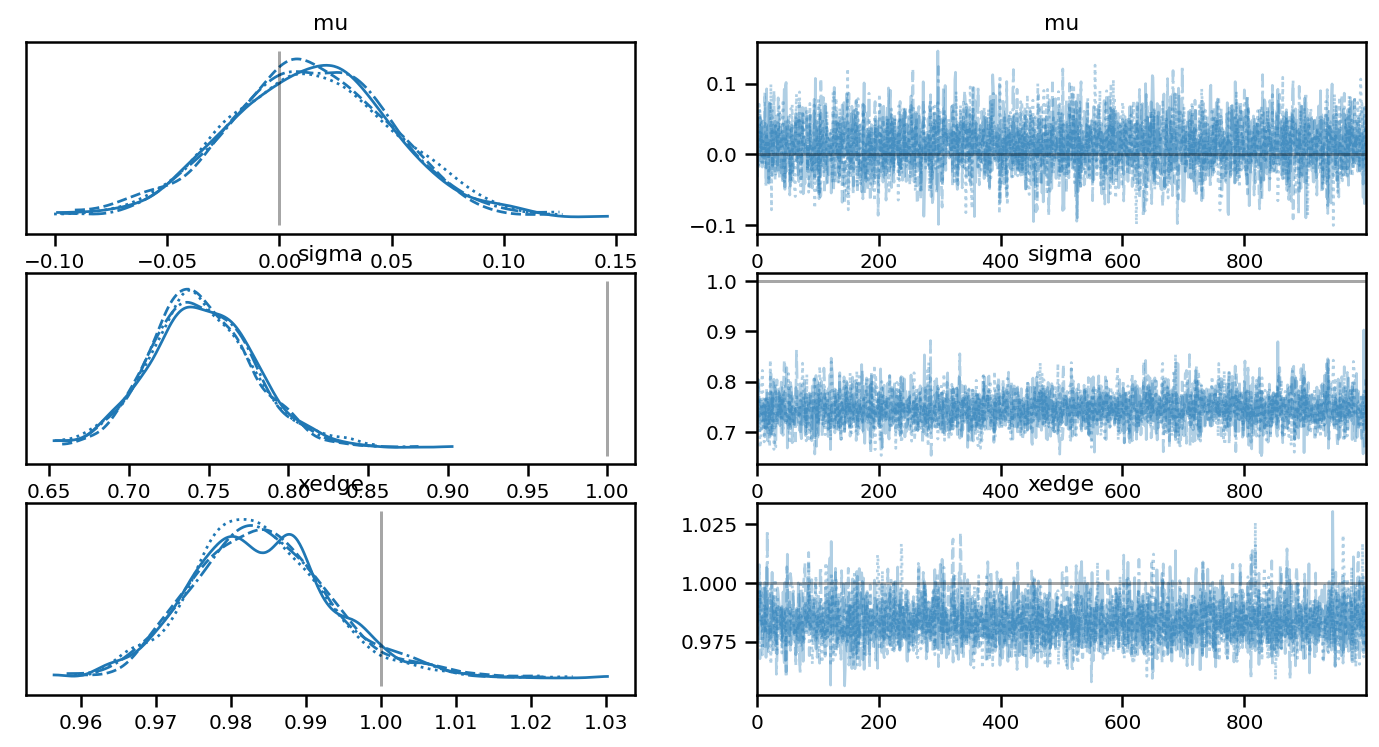

In [28]:
az.plot_trace(trace, 
              lines=[('mu', {}, mu), ('sigma', {}, sigma), ('xedge', {}, xedge)])

This doesn't work because we need to incorporate the upper limit on the integral over the selection effects, too!  (Unless the edge is many, many sigma away from the *mean* of the foreground distribution, which it won't be!)